## Breast Cancer Classification


### Install dependencies

In [1]:
!pip install -q datasets transformers
!pip install accelerate
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#load libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import numpy as np
import torch
from datasets import load_metric

### Main Code Begins

In [3]:
# Import wandb to log training and evaluation results
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
wandb.init(project="BEIT-BreastCancer-Classification-AH-BreakHis-AH-60-20-20-Shuffled",
           config={
               "batch_size": 16,
               "num_train_epochs": 15,
               "learning_rate": 0.5e-5,
               "warmup_ratio": 0.9,
               "dataset": "BreakHis",
               "gradient_accumulation_steps": 2

           })

wandb: Currently logged in as: sb777anallh (ahmed-alm). Use `wandb login --relogin` to force relogin


In [5]:
# Gpu Stats
!nvidia-smi

Mon Jul 24 12:22:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
# Connect notebook to HuggingFace hub
from huggingface_hub import notebook_login
notebook_login()

In [7]:
# Install Git-LFS to upload your model checkpoints:

%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

### Loading the dataset

In [8]:
# Load the Gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# # Uncomment this cell if unzipping the dataset
#import zipfile

#path_to_zip_file = '/content/drive/MyDrive/Breast_Cancer/Splitted-Resized.zip'
#directory_to_extract_to = '/content/drive/MyDrive/Breast_Cancer/Dataset-Resized'

#with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
#  zip_ref.extractall(directory_to_extract_to)

In [9]:
# Load the train/val dataset

dataset = load_dataset("/content/drive/MyDrive/Breast_Cancer/Dataset-Resized/Splitted-Resized", data_dir="./train+val/")

# Load the dataset
test_dataset=load_dataset("/content/drive/MyDrive/Breast_Cancer/Dataset-Resized/Splitted-Resized/test")

# merge both datasets
from datasets import concatenate_datasets
dataset_cc = concatenate_datasets([dataset['train'], test_dataset['train']])

Resolving data files:   0%|          | 0/8484 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/Splitted-Resized-632e1a231c91eb77/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2124 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/test-a513b6c1bbf69f2d/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
dataset_cc

Dataset({
    features: ['image', 'label'],
    num_rows: 10608
})

In [11]:
# Convert the class labels to an integer id
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label

{0: 'benign', 1: 'malignant'}

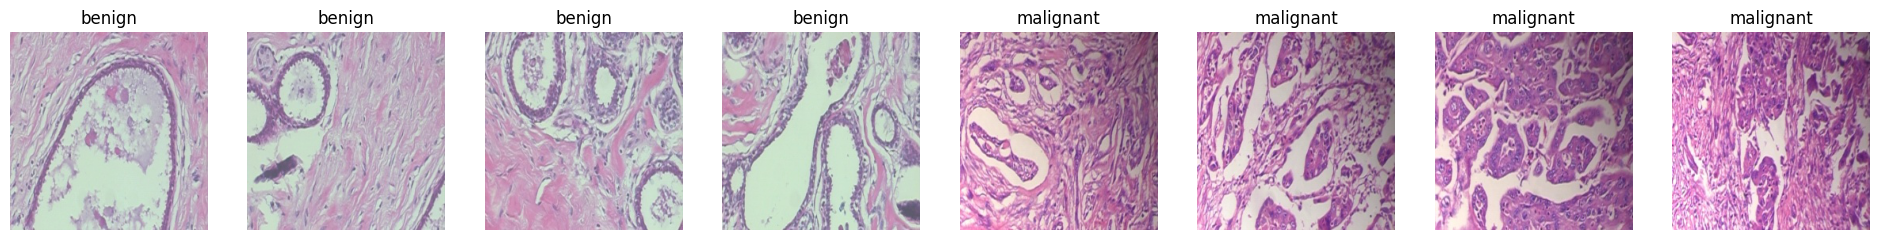

In [ ]:
# Select four image from each label
samples=[]
for i,row in enumerate(dataset['train']):
  if row['label'] not in [sample['label'] for sample in samples] or len([ sample['label'] for sample in samples if sample['label'] == row['label'] ]) < 4 :
    samples.append(row)
  if len(samples) == 24:
    break

# Display the selected images
fig, ax = plt.subplots(1, len(samples),  figsize=(24, 10))
for i,row in enumerate(samples):
  ax[i].imshow(row['image'])
  ax[i].set_title(id2label[samples[i]['label']])
  ax[i].axis('off')
plt.show()

In [12]:
# Entries in the dataset loaded
dataset_cc.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['benign', 'malignant'], id=None)}

In [13]:
dataset_cc.features["label"]

ClassLabel(names=['benign', 'malignant'], id=None)

### Preprocessing the data

In [14]:

# pre-trained model checkpoint to be used for fine-tuning
model_checkpoint = "microsoft/beit-large-patch16-224"

# batch size for training and evaluation
batch_size = 16

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [15]:
# Here we define 2 separate functions, one for training and one for validation
# This is used to apply some augmentation during the training

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_test(example_batch):
    """Apply test_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [16]:
# split up training into training + validation
splits = dataset_cc.train_test_split(test_size=0.2,shuffle=True, seed=45)
test_ds = splits['test']
train_splits=splits['train'].train_test_split(test_size=0.25)
train_ds = train_splits['train']
val_ds = train_splits['test']

In [17]:
# We will use the `set_transform` functionality, which allows to apply the functions above on-the-fly
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)
test_ds.set_transform(preprocess_test)

In [18]:
# Single image entry
test_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x250 at 0x7D13FD0FD030>,
 'label': 0,
 'pixel_values': tensor([[[ 0.3020,  0.1294, -0.0353,  ...,  0.3255,  0.3098,  0.3176],
          [ 0.2784,  0.1137, -0.0353,  ...,  0.3255,  0.3098,  0.3176],
          [ 0.2549,  0.0902, -0.0431,  ...,  0.3255,  0.3098,  0.3176],
          ...,
          [ 0.2235,  0.2157,  0.1843,  ...,  0.2235,  0.2235,  0.2235],
          [ 0.2314,  0.2392,  0.1529,  ...,  0.2471,  0.2314,  0.2235],
          [ 0.2471,  0.2471,  0.1373,  ...,  0.2863,  0.2784,  0.2784]],
 
         [[ 0.0902, -0.0588, -0.1922,  ...,  0.3804,  0.3804,  0.3961],
          [ 0.0745, -0.0745, -0.1922,  ...,  0.3725,  0.3804,  0.3961],
          [ 0.0510, -0.0980, -0.2000,  ...,  0.3725,  0.3804,  0.3961],
          ...,
          [ 0.2000,  0.1922,  0.1608,  ...,  0.3020,  0.3020,  0.3020],
          [ 0.2078,  0.2078,  0.1216,  ...,  0.3412,  0.3333,  0.3255],
          [ 0.2078,  0.2000,  0.0902,  ...,  0.4118, 

### Training the model

In [19]:
# Metric for assessing the trained model
metric = load_metric("accuracy")

<ipython-input-19-0940b35cbb2c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [20]:
# Load the model using it's configuration file and making the output as per the give classes


model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-large-patch16-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 1024]) in the checkpoint and torch.Size([2, 1024]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Congigure the Hyperparameters for the training

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20-Shuffled",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=0.5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    warmup_ratio=0.9,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
)

In [22]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)



# We also define a `collate_fn`, which will be used to batch examples together.
# Each batch consists of 2 keys, namely `pixel_values` and `labels`.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [23]:
# The trainer is the final instance ready to be trained for given model
# configurations and input data

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

Cloning https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20-Shuffled into local empty directory.


Download file pytorch_model.bin:   0%|          | 8.00k/1.13G [00:00<?, ?B/s]

Download file runs/Jul23_22-40-36_736a7a1321b9/events.out.tfevents.1690152083.736a7a1321b9.3138.0:  12%|#2    …

Download file training_args.bin: 100%|##########| 4.06k/4.06k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##4       | 1.00k/4.06k [00:00<?, ?B/s]

Clean file runs/Jul23_22-40-36_736a7a1321b9/events.out.tfevents.1690152083.736a7a1321b9.3138.0:   1%|         …

Clean file pytorch_model.bin:   0%|          | 1.00k/1.13G [00:00<?, ?B/s]

In [ ]:
# To remove any folder of the model trained
# !rm -r /content/convnextv2-large-1k-224-finetuned-Lesion-Classification-HAM10000-AH-60-20-20

In [26]:
# Start the training
train_results = trainer.train(resume_from_checkpoint=True)

# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy
15,0.000500,0.014596,0.995759


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/1.13G [00:00<?, ?B/s]

Upload file runs/Jul24_12-25-26_5e0297adb31f/events.out.tfevents.1690201848.5e0297adb31f.1343.0:   0%|        …

To https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20-Shuffled
   8125c84..daa1e2d  main -> main

   8125c84..daa1e2d  main -> main

To https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20-Shuffled
   daa1e2d..1012b2f  main -> main

   daa1e2d..1012b2f  main -> main



***** train metrics *****
  epoch                    =          15.0
  total_flos               = 24390787762GF
  train_loss               =        0.0015
  train_runtime            =    0:14:53.25
  train_samples_per_second =       106.868
  train_steps_per_second   =         3.342


In [27]:
trainer.state.best_metric

0.9957587181903864

In [28]:
# We can check with the `evaluate` method that our `Trainer` did reload the
# best model properly (if it was not the last one):

metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       15.0
  eval_accuracy           =     0.9958
  eval_loss               =     0.0146
  eval_runtime            = 0:01:26.46
  eval_samples_per_second =     24.541
  eval_steps_per_second   =      1.538


In [29]:
trainer.state.best_metric

0.9957587181903864

### Testing on Test Dataset

In [30]:
# Perform predictions
predictions, labels, metrics_test = trainer.predict(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  predict_accuracy           =     0.9972
  predict_loss               =     0.0132
  predict_runtime            = 0:09:26.17
  predict_samples_per_second =      3.748
  predict_steps_per_second   =      0.235


In [37]:
# Perform evaluatoin
metrics_test = trainer.evaluate(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  epoch                      =       15.0
  predict_accuracy           =     0.9972
  predict_loss               =     0.0132
  predict_runtime            = 0:01:26.58
  predict_samples_per_second =     24.506
  predict_steps_per_second   =      1.536


You can now upload the result of the training to the Hub, just execute this instruction :

In [31]:
# It allows the Trainer to push the model to the [Hub]
trainer.push_to_hub()

To https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20-Shuffled
   1012b2f..91ce6d9  main -> main

   1012b2f..91ce6d9  main -> main



'https://huggingface.co/ALM-AHME/beit-large-patch16-224-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20-Shuffled/commit/91ce6d908d885b1aadefdb83881ec8efe4c8ec72'

The trained model can be loaded using the following commands

```python
from transformers import AutoModelForImageClassification, AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("ahmedALM1221/convnextv2-large-1k-224-finetuned-eurosat-50")
model = AutoModelForImageClassification.from_pretrained("ahmedALM1221/convnextv2-large-1k-224-finetuned-eurosat-50")

```

# Compute metrics

In [32]:
#!pip install -q datasets transformers
#!pip install accelerate
#!pip install wandb

#load libraries
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
# Import the image processor compatible with the given model architecture
# Import the image processor compatible with the given model architecture
from transformers import AutoImageProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch
from datasets import load_metric
# metrics
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
import warnings

import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix

# compute all scores macro and weighted
def evaluation_summary(desc, predictions, true_labels):
    accuracy = accuracy_score(predictions, true_labels)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    f1 = fbeta_score(predictions, true_labels, beta=1, average='macro')
    weighted_precision = precision_score(predictions, true_labels, average='weighted')
    weighted_recall = recall_score(predictions, true_labels, average='weighted')
    weighted_f1 = fbeta_score(predictions, true_labels, beta=1, average='weighted')
    results = {
            "classifier": [desc],
            "accuracy": [round(accuracy,3)],
            "macro_precision": [round(precision,3)],
            "macro_recall": [round(recall,3)],
            "macro_f1": [round(f1,3)],
            "weighted_precision": [round(weighted_precision,3)],
            "weighted_recall": [round(weighted_recall,3)],
            "weighted_f1": [round(weighted_f1,3)]
            }
    return pd.DataFrame.from_dict(results)

In [ ]:
# Load the Gdrive

from google.colab import drive
drive.mount('/content/drive')

# Load the train/val dataset

dataset = load_dataset("/content/drive/MyDrive/Breast_Cancer/Dataset-Resized/Splitted-Resized", data_dir="./train+val/")

# Load the dataset
test_dataset=load_dataset("/content/drive/MyDrive/Breast_Cancer/Dataset-Resized/Splitted-Resized/test")

# merge both datasets
from datasets import concatenate_datasets
dataset_cc = concatenate_datasets([dataset['train'], test_dataset['train']])


# split up training into training + validation
splits = dataset_cc.train_test_split(test_size=0.2,shuffle=True, seed=45)
test_ds = splits['test']
train_splits=splits['train'].train_test_split(test_size=0.25)
train_ds = train_splits['train']
val_ds = train_splits['test']

Mounted at /content/drive


Resolving data files:   0%|          | 0/1223 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/test-60607148d1f081b8/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# pre-trained model checkpoint to be used for fine-tuning
model_checkpoint = "ALM-AHME/beit-large-patch16-224-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20-Shuffled"

# batch size for training and evaluation
batch_size = 16

image_processor  = AutoImageProcessor.from_pretrained(model_checkpoint)

In [ ]:
# Here we define 2 separate functions, one for training and one for validation
# This is used to apply some augmentation during the training

from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

test_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_test(example_batch):
    """Apply test_transforms across a batch."""
    example_batch["pixel_values"] = [test_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

# Convert the class labels to an integer id
labels = test_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label

{0: 'benign', 1: 'malignant'}

In [ ]:
test_ds.set_transform(preprocess_test)

# Metric for assessing the trained model
metric = load_metric("accuracy")


# Load the model using it's configuration file and making the output as per the give classes
model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = False, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

# Congigure the Hyperparameters for the training

model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    f"{model_name}-finetuned-BreastCancer-Classification-BreakHis-AH-60-20-20-Shuffled",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=0.5e-5,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=15,
    warmup_ratio=0.9,
    logging_steps=5,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)



# We also define a `collate_fn`, which will be used to batch examples together.
# Each batch consists of 2 keys, namely `pixel_values` and `labels`.
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


<ipython-input-5-c648cc331c03>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [ ]:
# The trainer is the final instance ready to be trained for given model
# configurations and input data
trainer = Trainer(
    model,
    args,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [36]:
# Perform predictions
predictions, labels, metrics_test = trainer.predict(test_ds, metric_key_prefix="predict")
trainer.log_metrics("predict", metrics_test)
#trainer.save_metrics("predict", metrics_test)

***** predict metrics *****
  predict_accuracy           =     0.9972
  predict_loss               =     0.0132
  predict_runtime            = 0:01:27.17
  predict_samples_per_second =     24.341
  predict_steps_per_second   =      1.526


<Axes: xlabel='Predicted Labels', ylabel='Actual Labels'>

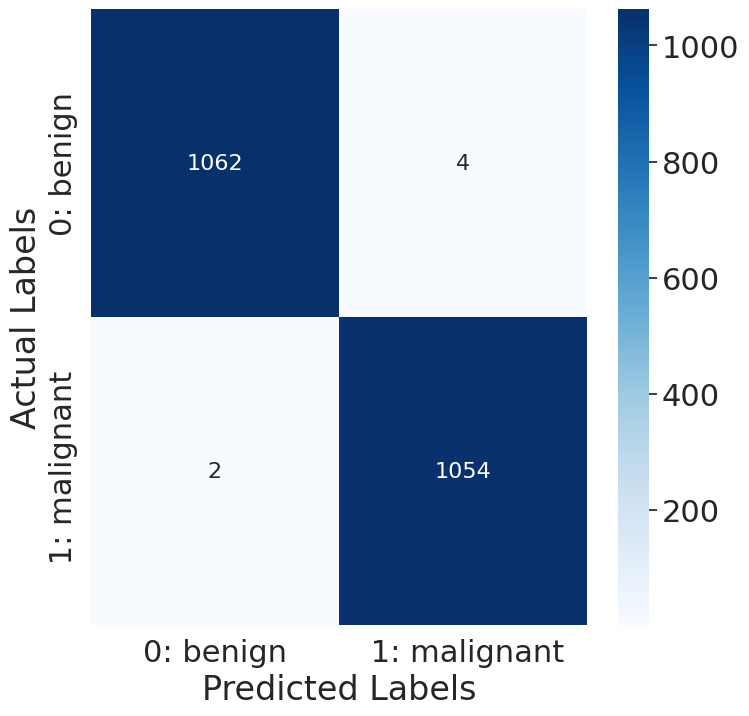

In [33]:
test_pred_labels=predictions.argmax(axis=1)

data = confusion_matrix(test_ds[:]['label'],test_pred_labels,labels=[0,1])
df_cm = pd.DataFrame(data, columns=['0: benign',' 1: malignant'], index = ['0: benign',' 1: malignant'])
df_cm.index.name = 'Actual Labels'
df_cm.columns.name = 'Predicted Labels'
plt.figure(figsize = (8,8))
sn.set(font_scale=2)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size


In [34]:
print(classification_report(test_ds[:]['label'],test_pred_labels,digits=4))

              precision    recall  f1-score   support

           0     0.9981    0.9962    0.9972      1066
           1     0.9962    0.9981    0.9972      1056

    accuracy                         0.9972      2122
   macro avg     0.9972    0.9972    0.9972      2122
weighted avg     0.9972    0.9972    0.9972      2122



In [35]:
beit_test_result=evaluation_summary("BEIT-finetuned-BreastCancer-Classification- Test data shuffled", test_pred_labels , test_ds[:]['label'])

summary_eval = pd.concat([beit_test_result], axis=0)
summary_eval = summary_eval.reset_index(drop=True)
color = (summary_eval.weighted_f1 > 0).map({True: 'background-color: green', False: ''})
summary_eval.style.apply(lambda s: color)

,classifier,accuracy,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
0,BEIT-finetuned-BreastCancer-Classification- Test data shuffled,0.997000,0.997000,0.997000,0.997000,0.997000,0.997000,0.997000
